<a href="https://colab.research.google.com/github/quantumalaviya/Predicting-Planetary-Albedo/blob/main/Messenger_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Task 2</h1>

Mounting drive to load the Messenger data which was pulled from github and uploaded prior to starting the project.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Importing relevant libraries

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import seaborn

In [ ]:
!ls gdrive/MyDrive/Messenger/Mercury

alsimap_smooth_032015.png.csv		    mercury-albedo-top-half.png.csv
casimap_smooth_032015.png.csv		    mgsimap_smooth_032015.png.csv
fesimap_smooth_032015.png.csv		    ssimap_smooth_032015.png.csv
mercury-albedo-resized-bottom-half.png.csv


Load data as numpy matrices and process for training

In [ ]:
albedo_top = np.genfromtxt('gdrive/MyDrive/Messenger/Mercury/mercury-albedo-top-half.png.csv', delimiter=',')
albedo_bot = np.genfromtxt('gdrive/MyDrive/Messenger/Mercury/mercury-albedo-resized-bottom-half.png.csv', delimiter=',')
alsi = np.genfromtxt('gdrive/MyDrive/Messenger/Mercury/alsimap_smooth_032015.png.csv', delimiter=',')
casi = np.genfromtxt('gdrive/MyDrive/Messenger/Mercury/casimap_smooth_032015.png.csv', delimiter=',')
fesi = np.genfromtxt('gdrive/MyDrive/Messenger/Mercury/fesimap_smooth_032015.png.csv', delimiter=',')
mgsi = np.genfromtxt('gdrive/MyDrive/Messenger/Mercury/mgsimap_smooth_032015.png.csv', delimiter=',')
ssi = np.genfromtxt('gdrive/MyDrive/Messenger/Mercury/ssimap_smooth_032015.png.csv', delimiter=',')

This is OpenCV's inpainting function (see suggested improvements)

In [ ]:
def inpaint(img):
  _, thresh = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY_INV)
  return cv2.inpaint(np.float32(img), np.uint8(thresh), 3, cv2.INPAINT_NS)

Using the same model as Task 1. This time no GAN is being used.

In [ ]:
import tensorflow as tf
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, ReLU, Dropout, Layer, LeakyReLU, Activation
from keras.optimizers import Adam

def block(input):
    conv1 = Conv2D(16, (3,3), padding = 'same')(input)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(16, (3,3), padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    
    maxpool1 = MaxPooling2D((2,2))(conv1)
    maxpool1 = Dropout(0.5)(maxpool1)
    
    conv2 = Conv2D(32, (3,3), padding = 'same')(maxpool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    conv2 = Conv2D(32, (3,3), padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    maxpool2 = MaxPooling2D((2,2))(conv2)  
    maxpool2 = Dropout(0.5)(maxpool2)
    
    conv3 = Conv2D(64, (3,3), padding = 'same')(maxpool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    conv3 = Conv2D(64, (3,3), padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    
    maxpool3 = MaxPooling2D((2,2))(conv3)
    maxpool3 = Dropout(0.5)(maxpool3)
    
    conv4 = Conv2D(128, (3,3), padding = 'same')(maxpool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(128, (3,3), padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)

    return conv1, conv2, conv3, conv4

def modUnet(Shape, no_inputs):
    input = []
    for i in range(no_inputs):
      input.append(Input(shape = Shape))

    c1 = []
    c2 = []
    c3 = []
    c4 = []

    for i in input:
      conv1, conv2, conv3, conv4 = block(i)
      c1.append(conv1)
      c2.append(conv2)
      c3.append(conv3)
      c4.append(conv4)

    if no_inputs > 1: 
      conv4 = concatenate(c4)
      conv3 = concatenate(c3)
      conv2 = concatenate(c2)
      conv1 = concatenate(c1)
    else:
      conv1, conv2, conv3, conv4 = c1[0], c2[0], c3[0], c4[0]

    up2 = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same')(conv4)
    up2 = concatenate([up2, conv3])
    up2 = Dropout(0.5)(up2)
    
    up2 = Conv2D(64, (3,3), padding = 'same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = ReLU()(up2)
    up2 = Conv2D(64, (3,3), padding = 'same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = ReLU()(up2) 
    
    
    up3 = Conv2DTranspose(32, (3,3), strides = (2,2), padding = 'same')(up2)
    up3 = concatenate([up3, conv2])
    up3 = Dropout(0.5)(up3)
    
    up3 = Conv2D(32, (3,3), padding = 'same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = ReLU()(up3)
    up3 = Conv2D(32, (3,3), padding = 'same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = ReLU()(up3) 
    
    
    up4 = Conv2DTranspose(16, (3,3), strides = (2,2), padding = 'same')(up3)
    up4 = concatenate([up4, conv1])
    
    up4 = Conv2D(16, (3,3), padding = 'same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = ReLU()(up4)
    up4 = Conv2D(16, (3,3), padding = 'same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = ReLU()(up4)
    
    output = Conv2D(1, (1, 1), activation='sigmoid') (up4)

    model = Model(input, output)

    return model

<h3>Predicting Fe/Si</h3>
According to the research paper, Fe/Si measurements are the most inconsistent and the most uncorrelated findings (especially in the Northern Hemisphere). It does seem to show a slight correlation with Mg. Thus, mg was used as a secondary input feature for better results.


In [ ]:
data = fesi

X = [cv2.resize(albedo_bot, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[360:][np.newaxis, :, :, np.newaxis]]
y = [inpaint(data[360:])[np.newaxis, :, :, np.newaxis]]
X_train = [cv2.resize(albedo_top, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[:360][np.newaxis, :, :, np.newaxis]]
y_train = [data[:360][np.newaxis, :, :, np.newaxis]]

In [ ]:
model = modUnet((360, 1440, 1), 2)
model.compile(loss = "mse", optimizer = Adam(1e-2), metrics = ["mae"])

#model.summary()

In [ ]:
history = model.fit(X, y, epochs = 500, validation_data = (X_train, y_train))

Epoch 1/500
1/1 [==============================] - 36s 36s/step - loss: 0.0292 - mae: 0.1323 - val_loss: 0.3581 - val_mae: 0.5518
Epoch 2/500
1/1 [==============================] - 1s 503ms/step - loss: 0.0299 - mae: 0.1310 - val_loss: 0.6417 - val_mae: 0.7086
Epoch 3/500
1/1 [==============================] - 1s 503ms/step - loss: 0.0140 - mae: 0.0870 - val_loss: 0.8258 - val_mae: 0.8726
Epoch 4/500
1/1 [==============================] - 0s 499ms/step - loss: 0.0112 - mae: 0.0772 - val_loss: 0.8272 - val_mae: 0.8740
Epoch 5/500
1/1 [==============================] - 0s 499ms/step - loss: 0.0084 - mae: 0.0683 - val_loss: 0.8259 - val_mae: 0.8726
Epoch 6/500
1/1 [==============================] - 0s 497ms/step - loss: 0.0078 - mae: 0.0670 - val_loss: 0.8259 - val_mae: 0.8726
Epoch 7/500
1/1 [==============================] - 0s 498ms/step - loss: 0.0069 - mae: 0.0641 - val_loss: 0.8257 - val_mae: 0.8725
Epoch 8/500
1/1 [==============================] - 1s 515ms/step - loss: 0.0065 - ma

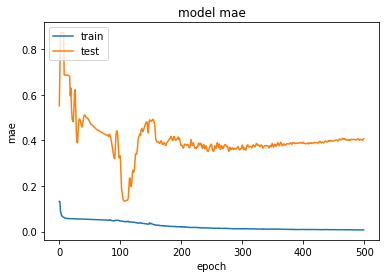

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

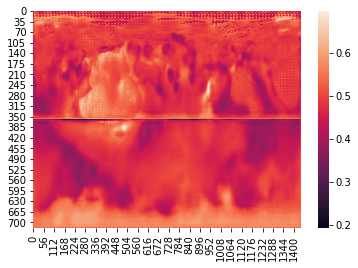

In [ ]:
x1 = np.concatenate([np.squeeze(model.predict(X_train)), np.squeeze(model.predict(X))])
seaborn.heatmap(x1)

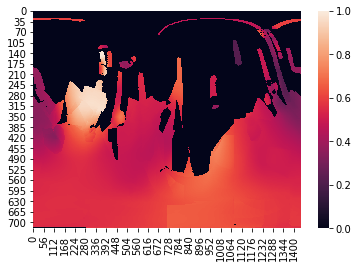

In [ ]:
seaborn.heatmap(fesi)

Evidently, Albedo is not correlated with elemental maps. Any neural network can fit dataset given enough capacity. See: https://arxiv.org/pdf/1611.03530.pdf

<h3>Predicting Mg/Si</h3>
This, other than Al, is the only map with global coverage. Both of these seem to be negatively correlated and hence is used as an input feature.

In [ ]:
data = mgsi

X = [cv2.resize(albedo_top, (1440, 360))[np.newaxis, :, :, np.newaxis], alsi[:360][np.newaxis, :, :, np.newaxis]]
y = [data[:360][np.newaxis, :, :, np.newaxis]]
X_train = [cv2.resize(albedo_bot, (1440, 360))[np.newaxis, :, :, np.newaxis], alsi[360:][np.newaxis, :, :, np.newaxis]]
y_train = [data[360:][np.newaxis, :, :, np.newaxis]]

In [ ]:
model = modUnet((360, 1440, 1), 2)
model.compile(loss = "mse", optimizer = Adam(1e-2), metrics = ["mae"])

#model.summary()

In [ ]:
history = model.fit(X, y, epochs = 500, validation_data = (X_train, y_train))

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 0.0672 - mae: 0.1895 - val_loss: 0.2776 - val_mae: 0.5236
Epoch 2/500
1/1 [==============================] - 1s 546ms/step - loss: 0.0422 - mae: 0.1728 - val_loss: 0.2812 - val_mae: 0.5250
Epoch 3/500
1/1 [==============================] - 1s 513ms/step - loss: 0.0306 - mae: 0.1364 - val_loss: 0.3134 - val_mae: 0.5574
Epoch 4/500
1/1 [==============================] - 1s 503ms/step - loss: 0.0176 - mae: 0.1028 - val_loss: 0.3136 - val_mae: 0.5573
Epoch 5/500
1/1 [==============================] - 1s 509ms/step - loss: 0.0176 - mae: 0.1029 - val_loss: 0.3136 - val_mae: 0.5573
Epoch 6/500
1/1 [==============================] - 1s 505ms/step - loss: 0.0165 - mae: 0.0984 - val_loss: 0.3136 - val_mae: 0.5573
Epoch 7/500
1/1 [==============================] - 1s 510ms/step - loss: 0.0156 - mae: 0.0946 - val_loss: 0.3136 - val_mae: 0.5573
Epoch 8/500
1/1 [==============================] - 1s 507ms/step - loss: 0.0152 - mae:

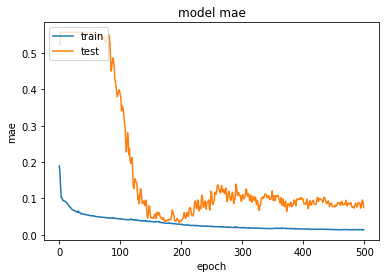

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

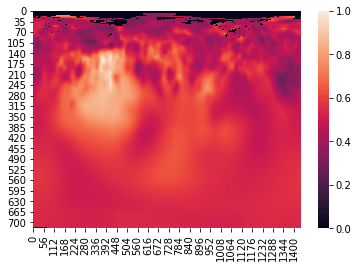

In [ ]:
seaborn.heatmap(mgsi)

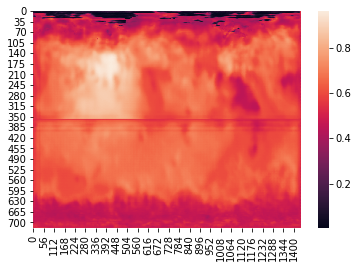

In [ ]:
x1 = np.concatenate([np.squeeze(model.predict(X)), np.squeeze(model.predict(X_train))])
seaborn.heatmap(x1)

<h3>Predicting Al/Si</h3>

In [ ]:
data = alsi

X = [cv2.resize(albedo_top, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[:360][np.newaxis, :, :, np.newaxis]]
y = [data[:360][np.newaxis, :, :, np.newaxis]]
X_train = [cv2.resize(albedo_bot, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[360:][np.newaxis, :, :, np.newaxis]]
y_train = [data[360:][np.newaxis, :, :, np.newaxis]]

In [ ]:
model = modUnet((360, 1440, 1), 2)
model.compile(loss = "mse", optimizer = Adam(1e-2), metrics = ["mae"])

#model.summary()

In [ ]:
history = model.fit(X, y, epochs = 500, validation_data = (X_train, y_train))

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 0.0829 - mae: 0.2159 - val_loss: 0.4447 - val_mae: 0.6539
Epoch 2/500
1/1 [==============================] - 1s 538ms/step - loss: 0.0356 - mae: 0.1322 - val_loss: 0.6970 - val_mae: 0.8313
Epoch 3/500
1/1 [==============================] - 1s 505ms/step - loss: 0.0249 - mae: 0.1066 - val_loss: 0.6970 - val_mae: 0.8313
Epoch 4/500
1/1 [==============================] - 1s 504ms/step - loss: 0.0219 - mae: 0.0990 - val_loss: 0.6652 - val_mae: 0.8084
Epoch 5/500
1/1 [==============================] - 0s 499ms/step - loss: 0.0199 - mae: 0.0953 - val_loss: 0.6317 - val_mae: 0.7825
Epoch 6/500
1/1 [==============================] - 1s 503ms/step - loss: 0.0182 - mae: 0.0900 - val_loss: 0.6812 - val_mae: 0.8206
Epoch 7/500
1/1 [==============================] - 1s 503ms/step - loss: 0.0183 - mae: 0.0886 - val_loss: 0.6970 - val_mae: 0.8313
Epoch 8/500
1/1 [==============================] - 1s 502ms/step - loss: 0.0190 - mae:

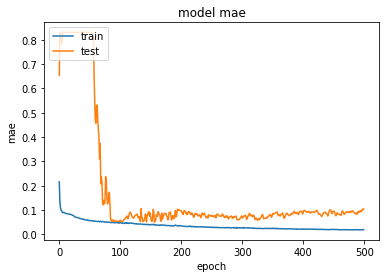

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

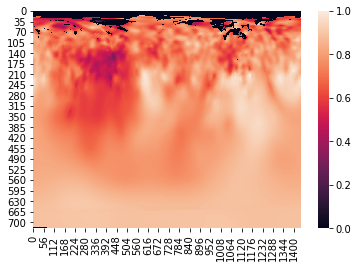

In [ ]:
seaborn.heatmap(alsi)

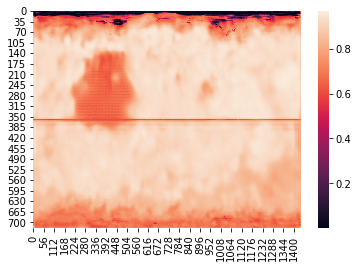

In [ ]:
x1 = np.concatenate([np.squeeze(model.predict(X)), np.squeeze(model.predict(X_train))])
seaborn.heatmap(x1)

<h3>Predicting Ca/Si</h3>
Ca deposits are positively correlated with Mg and the ratio of Ca/S yields a globally uniform map (as listed in the paper). Thus, Mg and S are used as secondary inputs.

In [ ]:
data = casi

X = [cv2.resize(albedo_bot, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[360:][np.newaxis, :, :, np.newaxis], ssi[360:][np.newaxis, :, :, np.newaxis]]
y = [data[360:][np.newaxis, :, :, np.newaxis]]
X_train = [cv2.resize(albedo_top, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[:360][np.newaxis, :, :, np.newaxis], ssi[:360][np.newaxis, :, :, np.newaxis]]
y_train = [data[:360][np.newaxis, :, :, np.newaxis]]

In [ ]:
model = modUnet((360, 1440, 1), 3)
model.compile(loss = "mse", optimizer = Adam(1e-2), metrics = ["mae"])

#model.summary()

In [ ]:
history = model.fit(X, y, epochs = 750, validation_data = (X_train, y_train))

Epoch 1/750
1/1 [==============================] - 7s 7s/step - loss: 0.0221 - mae: 0.1065 - val_loss: 0.1315 - val_mae: 0.2755
Epoch 2/750
1/1 [==============================] - 1s 699ms/step - loss: 0.0275 - mae: 0.1328 - val_loss: 0.2361 - val_mae: 0.4358
Epoch 3/750
1/1 [==============================] - 1s 699ms/step - loss: 0.0103 - mae: 0.0654 - val_loss: 0.2736 - val_mae: 0.4212
Epoch 4/750
1/1 [==============================] - 1s 694ms/step - loss: 0.0067 - mae: 0.0471 - val_loss: 0.3503 - val_mae: 0.4910
Epoch 5/750
1/1 [==============================] - 1s 693ms/step - loss: 0.0057 - mae: 0.0434 - val_loss: 0.3638 - val_mae: 0.5005
Epoch 6/750
1/1 [==============================] - 1s 694ms/step - loss: 0.0039 - mae: 0.0341 - val_loss: 0.3960 - val_mae: 0.5323
Epoch 7/750
1/1 [==============================] - 1s 695ms/step - loss: 0.0032 - mae: 0.0294 - val_loss: 0.4378 - val_mae: 0.5727
Epoch 8/750
1/1 [==============================] - 1s 700ms/step - loss: 0.0031 - mae:

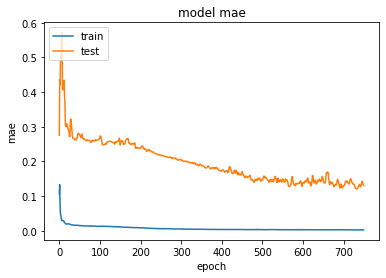

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

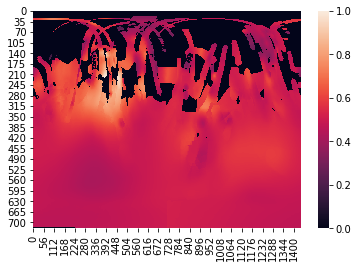

In [ ]:
seaborn.heatmap(casi)

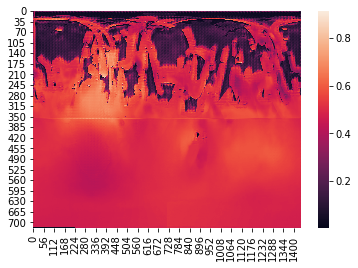

In [ ]:
x1 = np.concatenate([np.squeeze(model.predict(X_train)), np.squeeze(model.predict(X))])
seaborn.heatmap(x1)

<h3>Predicting S/Si</h3>

In [ ]:
data = ssi

X = [cv2.resize(albedo_bot, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[360:][np.newaxis, :, :, np.newaxis], casi[360:][np.newaxis, :, :, np.newaxis]]
y = [data[360:][np.newaxis, :, :, np.newaxis]]
X_train = [cv2.resize(albedo_top, (1440, 360))[np.newaxis, :, :, np.newaxis], mgsi[:360][np.newaxis, :, :, np.newaxis], casi[:360][np.newaxis, :, :, np.newaxis]]
y_train = [data[:360][np.newaxis, :, :, np.newaxis]]

In [ ]:
model = modUnet((360, 1440, 1), 3)
model.compile(loss = "mse", optimizer = Adam(1e-2), metrics = ["mae"])

#model.summary()

In [ ]:
history = model.fit(X, y, epochs = 750, validation_data = (X_train, y_train))

Epoch 1/750
1/1 [==============================] - 6s 6s/step - loss: 0.0622 - mae: 0.2187 - val_loss: 0.1613 - val_mae: 0.3305
Epoch 2/750
1/1 [==============================] - 1s 709ms/step - loss: 0.0225 - mae: 0.1145 - val_loss: 0.4127 - val_mae: 0.5944
Epoch 3/750
1/1 [==============================] - 1s 702ms/step - loss: 0.0122 - mae: 0.0594 - val_loss: 0.4739 - val_mae: 0.6369
Epoch 4/750
1/1 [==============================] - 1s 697ms/step - loss: 0.0085 - mae: 0.0490 - val_loss: 0.4847 - val_mae: 0.6436
Epoch 5/750
1/1 [==============================] - 1s 699ms/step - loss: 0.0069 - mae: 0.0431 - val_loss: 0.4440 - val_mae: 0.6056
Epoch 6/750
1/1 [==============================] - 1s 698ms/step - loss: 0.0053 - mae: 0.0379 - val_loss: 0.3889 - val_mae: 0.5373
Epoch 7/750
1/1 [==============================] - 1s 698ms/step - loss: 0.0043 - mae: 0.0330 - val_loss: 0.3976 - val_mae: 0.5440
Epoch 8/750
1/1 [==============================] - 1s 696ms/step - loss: 0.0037 - mae:

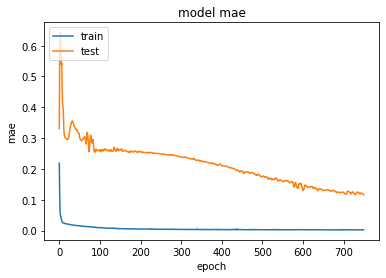

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

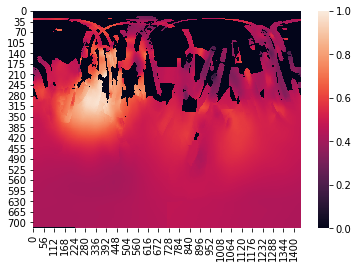

In [ ]:
seaborn.heatmap(ssi)

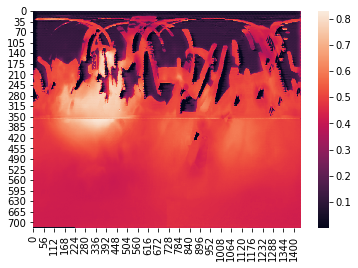

In [ ]:
x1 = np.concatenate([np.squeeze(model.predict(X_train)), np.squeeze(model.predict(X))])
seaborn.heatmap(x1)